Originally, I was going to get an API Key and pull data the easy way. I was hoping I could re-use some code from my WoW Auctionhouse project. Unfortunately, TCGPlayer no longer gives out API Keys:
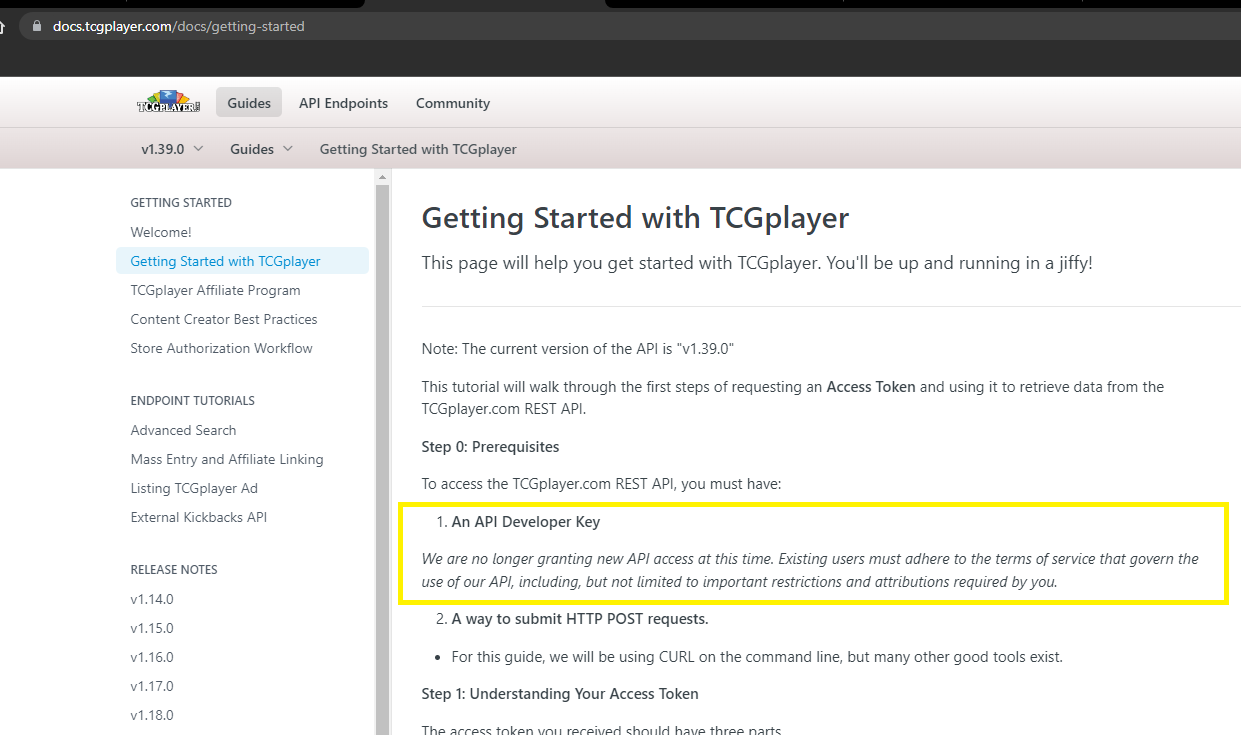

https://www.tcgplayer.com/product/271837/pokemon-swsh-sword-and-shield-promo-cards-arceus-v-swsh204?xid=pid6b335ca-da3c-4af8-8bd9-da62cdc4d35f&page=1&Language=English

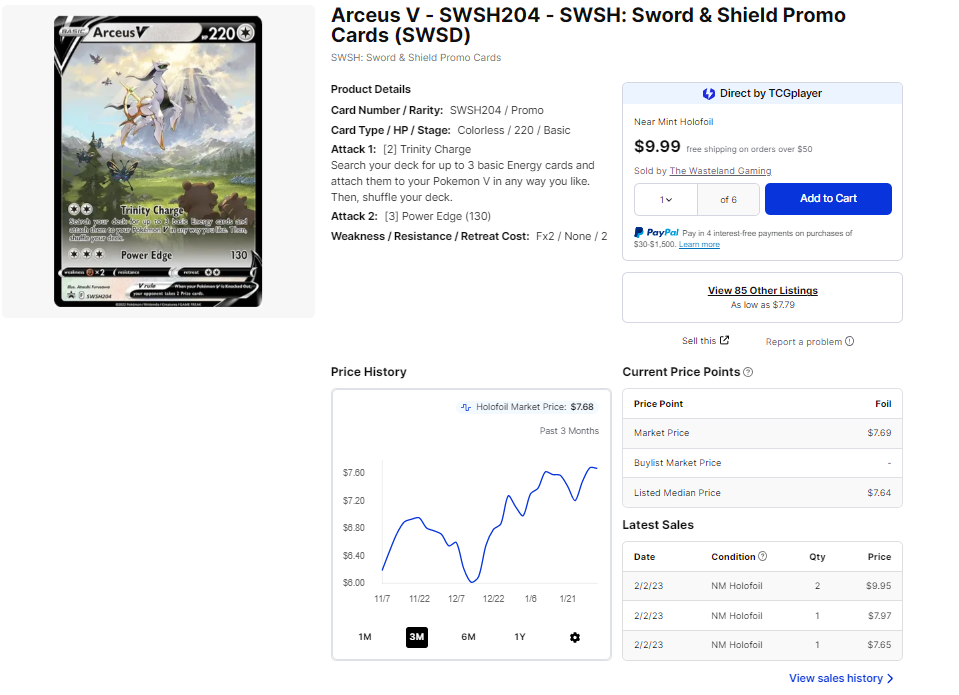

Hovering over the chart shows the price at a certain date. Current price is also listed:
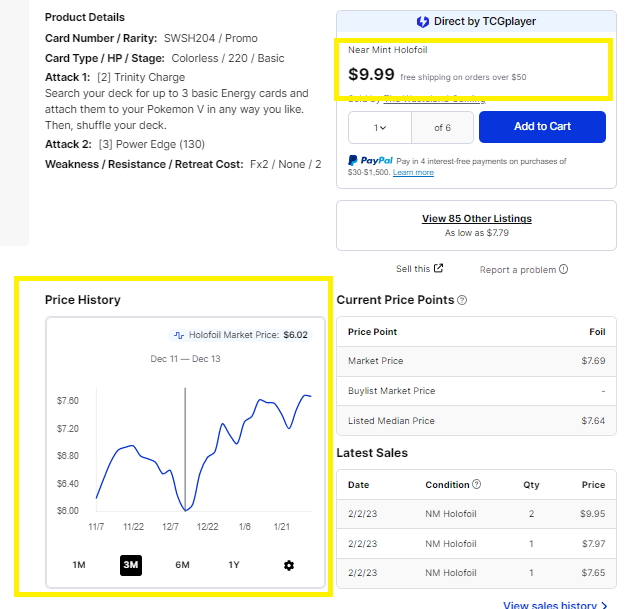

After some poking around, it looks like historical data is stored on the site itself for the chart. The name of the connection start with "[ItemID]?range=quarter":
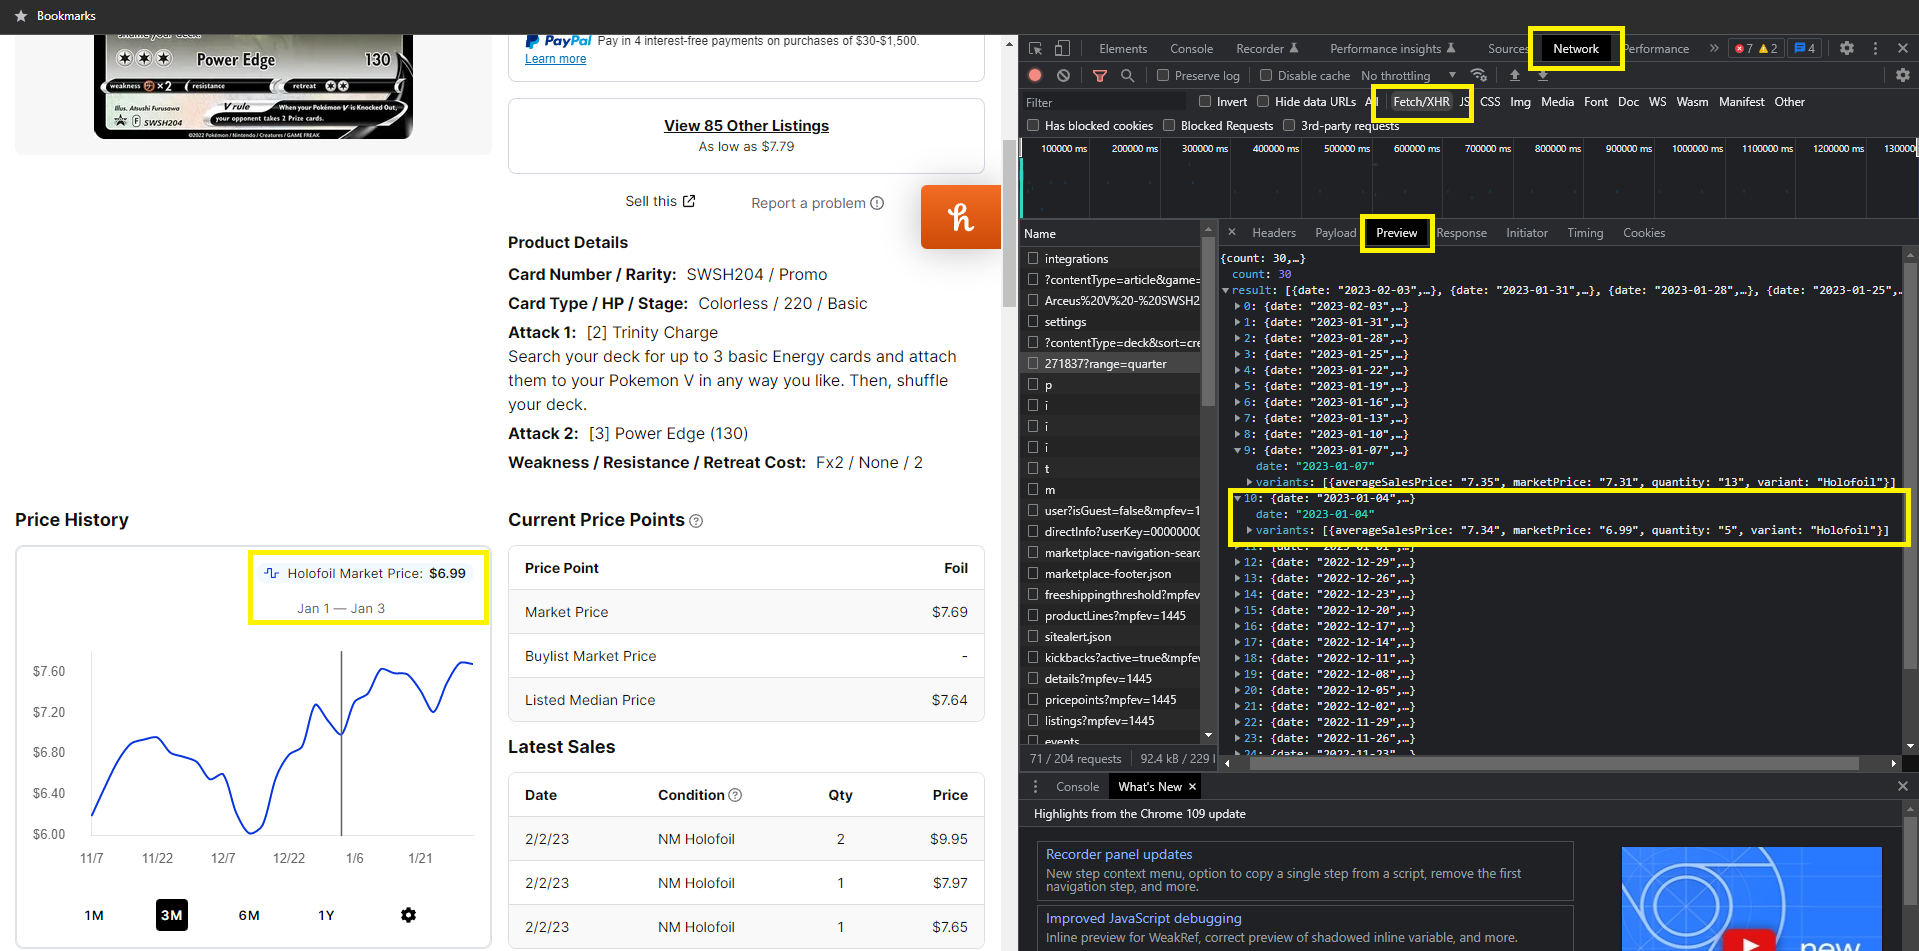

ItemID found in URL:
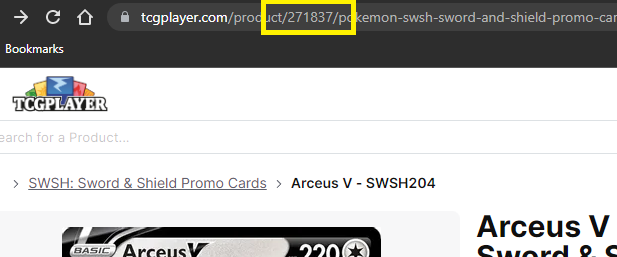

Example of data in background found in chart:
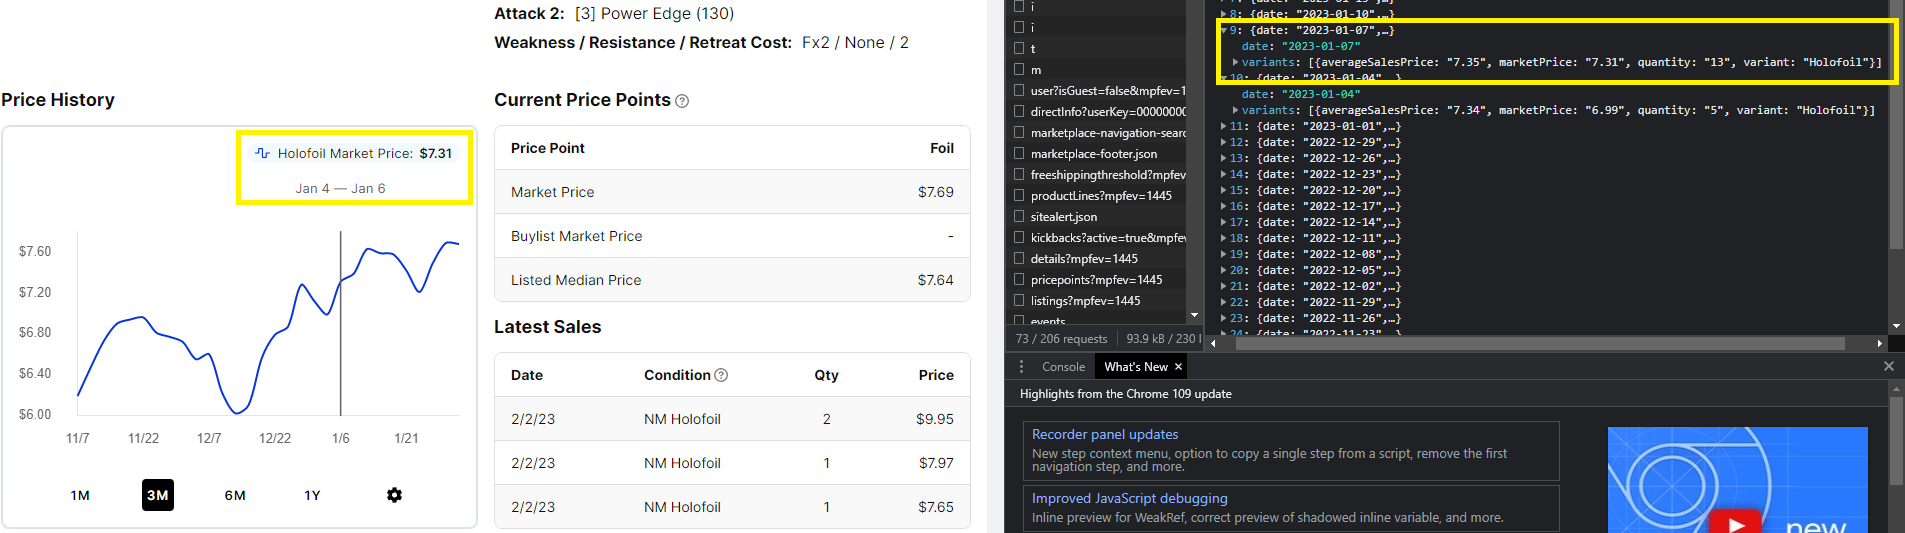

The index on the table seems to be date blocks since current date. For example, this data was viewed on 2023-02-03. The zero index is dated 2023-02-03. Since the one index is 2023-01-31, this is the average marketPrice for cards within this date block. The marketPrice listed on the chart is one behind on the date listed on the table. In this example, 2023-01-07 has a $7.31 marketPrice showing the price started date block of 2023-01-06 to 2023-01-06 ended at this price. At this point, it wasn't a matter of -if- the data could be found, it was -how- was the best way to pull it. Luckily, I found a tutorial:

https://medium.com/analytics-vidhya/an-easy-technique-for-web-scraping-an-interactive-web-chart-38f5f945ca63

In [1]:
import requests as r
import json
from pandas.io.json import json_normalize

#url to post
action_postURL = 'https://infinite-api.tcgplayer.com/price/history/271837?range=annual'

#get data from that URL
res = r.get(action_postURL)

#put the data coming in from res into values as json
values = res.json()

In [2]:
values.keys()

dict_keys(['count', 'result'])

The website returns two things: A count of how many days there are in the data and the data for each day. The count is going to be useful for loops. Save it, put it to the side:

In [3]:
NumberOfDays= values['count']
print(str(type(NumberOfDays)) + ': ' + str(NumberOfDays))

<class 'int'>: 52


In [4]:
#peak at the results for each day
values['result'][0]

{'date': '2023-02-08',
 'variants': [{'averageSalesPrice': '6.52',
   'marketPrice': '6.42',
   'quantity': '8',
   'variant': 'Holofoil'}]}

The count of days and the results are in the same dictionary. Seperate them:

In [5]:
results = []
i = 0
while i < NumberOfDays:
    results.append(values['result'][i])
    i = i + 1

Seperating them results in a dictionary with the date and the variants:

In [6]:
results[0]["date"]

'2023-02-08'

In [7]:
results[-1]["date"]

'2022-02-21'

In [8]:
results[0]["variants"]

[{'averageSalesPrice': '6.52',
  'marketPrice': '6.42',
  'quantity': '8',
  'variant': 'Holofoil'}]

In [9]:
results[0]['variants']

[{'averageSalesPrice': '6.52',
  'marketPrice': '6.42',
  'quantity': '8',
  'variant': 'Holofoil'}]

Varients are for cards that have more than one type. For example, there are some cards that come in holofoil and non-holofoil. For the ETL, I'm going to add this as a filter. It might be useful when chasing specific cards in the future.

In [10]:
results[0]['variants'][0]['variant'] == 'Holofoil'

True

In [11]:
for row in range(0,len(results[0]['variants'])):
    if results[0]['variants'][row]['variant'] == 'Holofoil':
        print('Market price = ' + results[0]['variants'][row]['marketPrice'])
        print('Quantity = ' + results[0]['variants'][row]['quantity'])
        print('Date = ' + results[0]["date"])

Market price = 6.42
Quantity = 8
Date = 2023-02-08


And with that, I have enough to start working on getting the historic data of the card! The above code was later re-ran to pull a year's worth of data. I'll need to add a filter to find the first date each card was available and remove any empty dates prior to that:

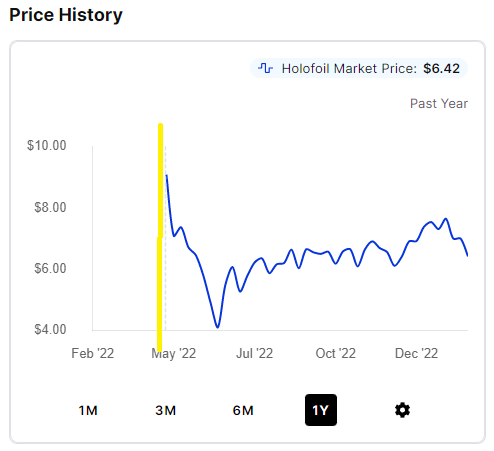

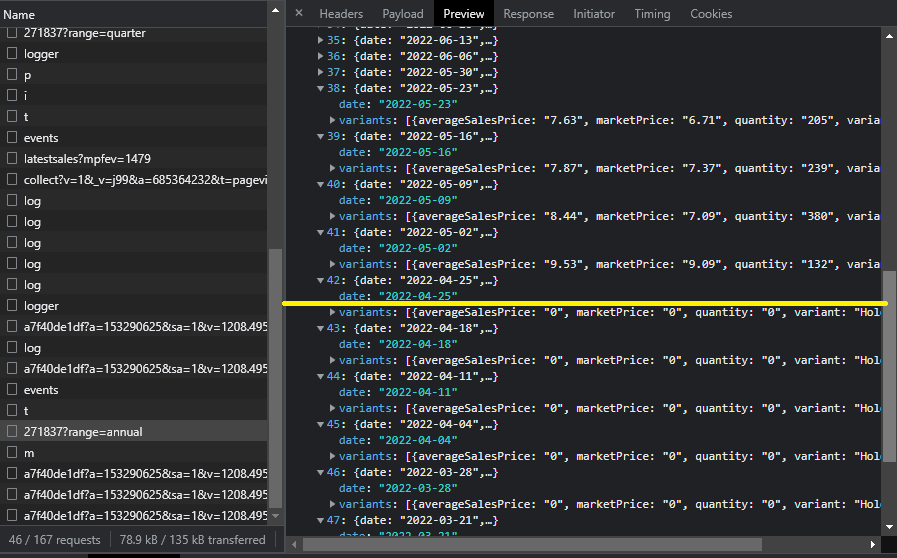